In [14]:
import os
from glob import glob

import numpy as np
import torch
import torchvision
import tqdm
import imageio
import cv2
import matplotlib.pyplot as plt

from albumentations import HorizontalFlip, VerticalFlip, Rotate

# Augmentation

In [15]:
path = './DRIVE/'

train_x = sorted(glob(os.path.join(path, 'training', 'images', '*.tif')))
train_y = sorted(glob(os.path.join(path, 'training', '1st_manual', '*.gif')))

test_x = sorted(glob(os.path.join(path, 'test', 'images', '*.tif')))
test_y = sorted(glob(os.path.join(path, 'test', '1st_manual', '*.gif')))

print(len(train_x), len(test_x))

20 20


In [16]:
! mkdir './final_data'
! mkdir './final_data/train'
! mkdir './final_data/test'

! mkdir './final_data/train/image'
! mkdir './final_data/train/mask'

! mkdir './final_data/test/image'
! mkdir './final_data/test/mask'

mkdir: cannot create directory ‘./final_data’: File exists
mkdir: cannot create directory ‘./final_data/train’: File exists
mkdir: cannot create directory ‘./final_data/test’: File exists
mkdir: cannot create directory ‘./final_data/train/image’: File exists
mkdir: cannot create directory ‘./final_data/train/mask’: File exists
mkdir: cannot create directory ‘./final_data/test/image’: File exists
mkdir: cannot create directory ‘./final_data/test/mask’: File exists


In [17]:
def aug(images, mask, save_path, augment):
    size = (512, 512)

    for idx, (x, y) in tqdm.tqdm(enumerate(zip(images, mask)), total=len(images)):
        name = x.split('/')[-1].split('.')[0]
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]


        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = Rotate(limit=60, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]
        else:
            X = [x]
            Y = [y]
        
        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            img_name = f'{name}-{index}.png'
            mask_name = f'{name}-{index}.png'

            cv2.imwrite(os.path.join(save_path, 'image', img_name), i)
            cv2.imwrite(os.path.join(save_path, 'mask', mask_name), m)

            index += 1


In [18]:
aug(train_x, train_y, './final_data/train', augment=True)

100%|██████████| 20/20 [00:01<00:00, 11.45it/s]


In [19]:
aug(test_x, test_y, './final_data/test', augment=False)

100%|██████████| 20/20 [00:00<00:00, 27.57it/s]


In [20]:
class DriveDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   # type: ignore ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [21]:
class Convolution(torch.nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_c)

        self.conv2 = torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_c)

        self.relu = torch.nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class Encoder(torch.nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = Convolution(in_c, out_c)
        self.pool = torch.nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class Decoder(torch.nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = torch.nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = Convolution(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1) # type: ignore
        x = self.conv(x)
        return x

class Unet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = Encoder(3, 64)
        self.e2 = Encoder(64, 128)
        self.e3 = Encoder(128, 256)
        self.e4 = Encoder(256, 512)

        """ Bottleneck """
        self.b = Convolution(512, 1024)

        """ Decoder """
        self.d1 = Decoder(1024, 512)
        self.d2 = Decoder(512, 256)
        self.d3 = Decoder(256, 128)
        self.d4 = Decoder(128, 64)

        """ Classifier """
        self.outputs = torch.nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

In [22]:
class Up_Conv(torch.nn.Module):
    def __init__(self,in_c,out_c):
        super(Up_Conv,self).__init__()
        self.up = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(in_c,out_c,kernel_size=3,stride=1,padding=1,bias=True),
		    torch.nn.BatchNorm2d(out_c),
			torch.nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return 


class Attention_block(torch.nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = torch.nn.Sequential(
            torch.nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            torch.nn.BatchNorm2d(F_int)
            )
        
        self.W_x = torch.nn.Sequential(
            torch.nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            torch.nn.BatchNorm2d(F_int)
        )

        self.psi = torch.nn.Sequential(
            torch.nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            torch.nn.BatchNorm2d(1),
            torch.nn.Sigmoid()
        )
        
        self.relu = torch.nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


class Att_UNet(torch.nn.Module):
    def __init__(self):
        super(Att_UNet, self).__init__()
        
        self.Maxpool = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = Convolution(in_c=3, out_c=64)
        self.Conv2 = Convolution(in_c=64, out_c=128)
        self.Conv3 = Convolution(in_c=128, out_c=256)
        self.Conv4 = Convolution(in_c=256, out_c=512)
        self.Conv5 = Convolution(in_c=512, out_c=1024)

        self.Up5 = Up_Conv(in_c=1024,out_c=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = Convolution(in_c=1024, out_c=512)

        self.Up4 = Up_Conv(in_c=512,out_c=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = Convolution(in_c=512, out_c=256)
        
        self.Up3 = Up_Conv(in_c=256,out_c=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = Convolution(in_c=256, out_c=128)
        
        self.Up2 = Up_Conv(in_c=128,out_c=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = Convolution(in_c=128, out_c=64)

        self.Conv_1x1 = torch.nn.Conv2d(64,1,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [23]:

class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [24]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [25]:
train_x = sorted(glob("./final_data/train/image/*"))
train_y = sorted(glob("./final_data/train/mask/*"))

valid_x = sorted(glob("./final_data/test/image/*"))
valid_y = sorted(glob("./final_data/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

Dataset Size:
Train: 80 - Valid: 20



In [26]:
H = 512
W = 512
size = (H, W)
batch_size = 2
num_epochs = 50
lr = 1e-4
if not os.path.exists('./checkpts'):
    os.mkdir('./checkpts')
checkpoint_path = "checkpts/checkpoint.pth"

In [27]:
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

device = torch.device('cuda')   ## GTX 1650 Mobile 4GB
model = Att_UNet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

""" Training the model """
best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(num_epochs)):

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)

    """ Saving the model """
    if valid_loss < best_valid_loss:

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'

  0%|          | 0/50 [00:00<?, ?it/s]


TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [ ]:
image = cv2.imread('./test.jpg')
image = cv2.resize(image, (512, 512))
x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
print(x.shape)
x = x/255.0 # type: ignore
x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
x = x.astype(np.float32)
x = torch.from_numpy(x)
x = x.to('cpu')

(3, 512, 512)


In [ ]:
device = torch.device('cpu') 

model = Unet()
model = model.to(device)
model.load_state_dict(torch.load('./checkpts/checkpoint.pth', map_location=device))

<All keys matched successfully>

In [ ]:
pred = model(x)
pred

tensor([[[[-5.2837, -5.7097, -5.8216,  ..., -5.6620, -5.5742, -5.3890],
          [-5.5466, -5.5816, -5.7590,  ..., -5.5260, -5.5089, -5.5151],
          [-5.7181, -5.7471, -5.8596,  ..., -5.7862, -5.6016, -5.6620],
          ...,
          [-5.5644, -5.6352, -5.7054,  ..., -5.6261, -5.4868, -5.5261],
          [-5.4941, -5.5897, -5.6558,  ..., -5.6078, -5.4780, -5.4296],
          [-5.3711, -5.4933, -5.6179,  ..., -5.6351, -5.4249, -5.2427]]]],
       grad_fn=<ConvolutionBackward0>)

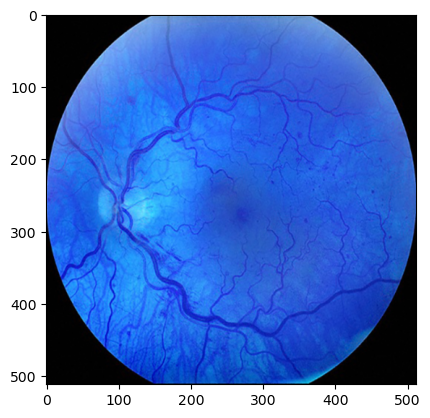

In [ ]:
plt.imshow(image, cmap=None)

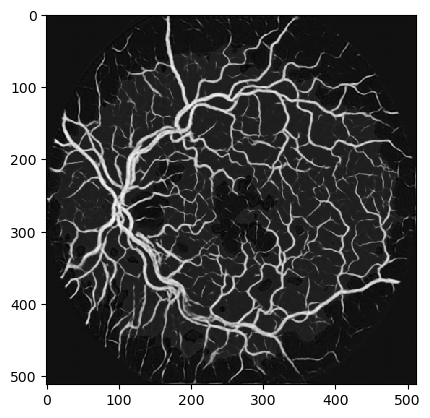

In [ ]:
plt.imshow(pred.detach().numpy()[0][0], cmap='Greys_r', interpolation='nearest')